## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [53]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [54]:
# ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [55]:
data.isnull().any()

user_id     False
date        False
group       False
purchase    False
price       False
dtype: bool

In [56]:
data.drop(287407, inplace=True)

In [57]:
# ваш код здесь
data.date = pd.to_datetime(data.date)

In [58]:
data.groupby('group').date.min()

group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [59]:
# ваш код здесь
data.groupby('group').agg({"user_id":"count"})

,user_id
group,
A,147201
B,147276


In [60]:
data.groupby('group').agg({"purchase":"sum"})

,purchase
group,
A,17723
B,17514


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [61]:
# ваш код здесь
user_intersection = set(data[data.group=='A'].user_id).intersection(set(data[data.group=='B'].user_id))
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [62]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

![image.png](attachment:95f235d2-6323-4799-bf69-697fc57f727b.png)
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [63]:
# ваш код здесь
df = updated_data.groupby('group').agg({'user_id':'count', 'purchase': 'sum', 'price':'sum'})
df.columns = ['count_visits', 'count_purchases', 'sum_price']
df

,count_visits,count_purchases,sum_price
group,,,
A,145306,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

ваши выводы здесь -  Сопоставимо количество посещений обоих вариантов посадочной странице, можно говорить о сбалансированности выборок

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [64]:
# ваш код здесь
df['conversion'] = df.count_purchases / df.count_visits * 100
df['mean_check'] = df.sum_price / df.count_purchases
df

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145306,17487,1417780000,12.034603,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

ваши выводы здесь

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [65]:
# ваш код здесь
df2 = updated_data.groupby(['group', 'price']).agg({'user_id':'count'})
df2

user_id
group price          
A     0        127819
      10000      5182
      60000      5271
      100000     1832
      150000     3478
      200000     1724
B     0        128091
      10000      5201
      60000      1730
      100000     5227
      150000     3438
      200000     1694

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах? - в группе В она выше в суммах 10000 и 100000

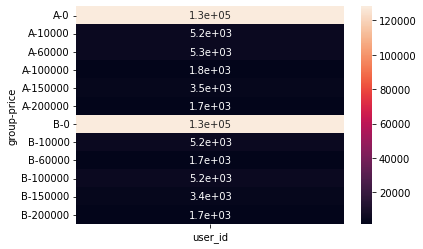

In [66]:
# ваш код здесь
sns.heatmap(df2, annot=True)

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

ваши выводы здесь - в группе В она выше в суммах 10000 и 100000

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [67]:
# ваш код здесь
df3 = updated_data.groupby(['group', 'date']).agg({'user_id':'count', 'purchase': 'sum', 'price':'sum'})
df3.columns = ['count_visits', 'count_purchases', 'sum_price']
df3

count_visits  count_purchases  sum_price
group date                                                
A     2021-01-02          2854              359   29410000
      2021-01-03          6596              748   62000000
      2021-01-04          6566              799   64250000
      2021-01-05          6433              790   64550000
      2021-01-06          6606              764   63410000
      2021-01-07          6579              795   67290000
      2021-01-08          6687              798   65380000
      2021-01-09          6633              794   65610000
      2021-01-10          6659              759   58950000
      2021-01-11          6699              797   58760000
      2021-01-12          6540              795   68460000
      2021-01-13          6564              764   63590000
      2021-01-14          6543              825   65890000
      2021-01-15          6700              806   67570000
      2021-01-16          6601              808   66210000
      2021-01-17          6619              809   63020000
      2021-01-18          6511              812   62850000
      2021-01-19          6582              790   63680000
      2021-01-20          6533              749   58710000
      2021-01-21          6750              851   70300000
      2021-01-22          6587              788   63690000
      2021-01-23          6698              843   70950000
      2021-01-24          3766              444   33250000
B     2021-01-02          2861              345   29660000
      2021-01-03          6619              754   65960000
      2021-01-04          6536              764   68030000
      2021-01-05          6511              749   63550000
      2021-01-06          6751              838   75020000
      2021-01-07          6616              767   67170000
      2021-01-08          6714              812   71270000
      2021-01-09          6628              784   71410000
      2021-01-10          6701              846   78080000
      2021-01-11          6679              770   66960000
      2021-01-12          6635              807   70560000
      2021-01-13          6495              720   65910000
      2021-01-14          6608              792   68990000
      2021-01-15          6563              747   69160000
      2021-01-16          6544              786   70560000
      2021-01-17          6546              831   75300000
      2021-01-18          6603              822   72240000
      2021-01-19          6562              772   67820000
      2021-01-20          6685              790   69250000
      2021-01-21          6555              760   69870000
      2021-01-22          6659              787   68660000
      2021-01-23          6633              805   68930000
      2021-01-24          3677              442   38650000

In [68]:
df3['conversion'] = df3.count_purchases / df3.count_visits * 100
df3['mean_check'] = df3.sum_price / df3.count_purchases
df3

count_visits  count_purchases  sum_price  conversion  \
group date                                                               
A     2021-01-02          2854              359   29410000   12.578837   
      2021-01-03          6596              748   62000000   11.340206   
      2021-01-04          6566              799   64250000   12.168748   
      2021-01-05          6433              790   64550000   12.280429   
      2021-01-06          6606              764   63410000   11.565244   
      2021-01-07          6579              795   67290000   12.083903   
      2021-01-08          6687              798   65380000   11.933603   
      2021-01-09          6633              794   65610000   11.970451   
      2021-01-10          6659              759   58950000   11.398108   
      2021-01-11          6699              797   58760000   11.897298   
      2021-01-12          6540              795   68460000   12.155963   
      2021-01-13          6564              764   63590000   11.639244   
      2021-01-14          6543              825   65890000   12.608895   
      2021-01-15          6700              806   67570000   12.029851   
      2021-01-16          6601              808   66210000   12.240570   
      2021-01-17          6619              809   63020000   12.222390   
      2021-01-18          6511              812   62850000   12.471203   
      2021-01-19          6582              790   63680000   12.002431   
      2021-01-20          6533              749   58710000   11.464871   
      2021-01-21          6750              851   70300000   12.607407   
      2021-01-22          6587              788   63690000   11.962957   
      2021-01-23          6698              843   70950000   12.585847   
      2021-01-24          3766              444   33250000   11.789697   
B     2021-01-02          2861              345   29660000   12.058721   
      2021-01-03          6619              754   65960000   11.391449   
      2021-01-04          6536              764   68030000   11.689106   
      2021-01-05          6511              749   63550000   11.503609   
      2021-01-06          6751              838   75020000   12.412976   
      2021-01-07          6616              767   67170000   11.593108   
      2021-01-08          6714              812   71270000   12.094132   
      2021-01-09          6628              784   71410000   11.828606   
      2021-01-10          6701              846   78080000   12.624981   
      2021-01-11          6679              770   66960000   11.528672   
      2021-01-12          6635              807   70560000   12.162773   
      2021-01-13          6495              720   65910000   11.085450   
      2021-01-14          6608              792   68990000   11.985472   
      2021-01-15          6563              747   69160000   11.381990   
      2021-01-16          6544              786   70560000   12.011002   
      2021-01-17          6546              831   75300000   12.694775   
      2021-01-18          6603              822   72240000   12.448887   
      2021-01-19          6562              772   67820000   11.764706   
      2021-01-20          6685              790   69250000   11.817502   
      2021-01-21          6555              760   69870000   11.594203   
      2021-01-22          6659              787   68660000   11.818591   
      2021-01-23          6633              805   68930000   12.136288   
      2021-01-24          3677              442   38650000   12.020669   

                    mean_check  
group date                      
A     2021-01-02  81922.005571  
      2021-01-03  82887.700535  
      2021-01-04  80413.016270  
      2021-01-05  81708.860759  
      2021-01-06  82997.382199  
      2021-01-07  84641.509434  
      2021-01-08  81929.824561  
      2021-01-09  82632.241814  
      2021-01-10  77667.984190  
      2021-01-11  73726.474279  
      2021-01-12  86113.207547  
      2021-01-13  83232.984293  
   

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [69]:
# ваш код здесь
df3 = df3.reset_index()
# df3.loc[:, 'count_visits_cum'] = df3[df3.group=='A'].count_visits.cumsum()
# df3.loc[:, 'count_visits_cum'] = df3[df3.group=='B'].count_visits.cumsum()
df3a = df3[df3.group=='A']
df3a['count_visits_cum'] = df3a.count_visits.cumsum()
df3a['count_purchases_cum'] = df3a.count_purchases.cumsum()
df3a['sum_price_cum'] = df3a.sum_price.cumsum()
# df3a
df3b = df3[df3.group=='B']
df3b['count_visits_cum'] = df3b.count_visits.cumsum()
df3b['count_purchases_cum'] = df3b.count_purchases.cumsum()
df3b['sum_price_cum'] = df3b.sum_price.cumsum()
# df3b
df4 = pd.concat([df3a, df3b])
df4['conversion_cum'] = df4.count_purchases_cum / df4.count_visits_cum * 100
df4['mean_check_cum'] = df4.sum_price_cum / df4.count_purchases_cum
df4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,group,date,count_visits,count_purchases,sum_price,conversion,mean_check,count_visits_cum,count_purchases_cum,sum_price_cum,conversion_cum,mean_check_cum
0,A,2021-01-02,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,A,2021-01-03,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
2,A,2021-01-04,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530
3,A,2021-01-05,6433,790,64550000,12.280429,81708.860759,22449,2696,220210000,12.009444,81680.267062
4,A,2021-01-06,6606,764,63410000,11.565244,82997.382199,29055,3460,283620000,11.908449,81971.098266
5,A,2021-01-07,6579,795,67290000,12.083903,84641.509434,35634,4255,350910000,11.940843,82470.035253
6,A,2021-01-08,6687,798,65380000,11.933603,81929.824561,42321,5053,416290000,11.939699,82384.721947
7,A,2021-01-09,6633,794,65610000,11.970451,82632.241814,48954,5847,481900000,11.943866,82418.334188
8,A,2021-01-10,6659,759,58950000,11.398108,77667.984190,55613,6606,540850000,11.878518,81872.540115
9,A,2021-01-11,6699,797,58760000,11.897298,73726.474279,62312,7403,599610000,11.880537,80995.542348


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

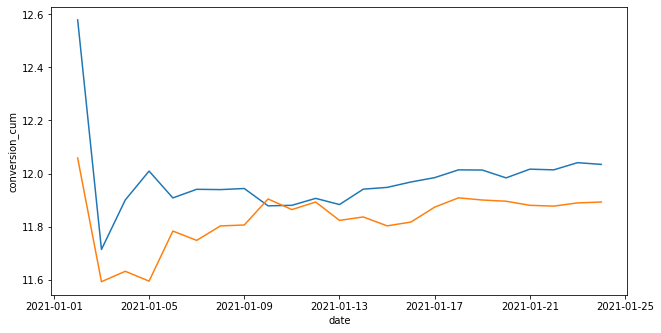

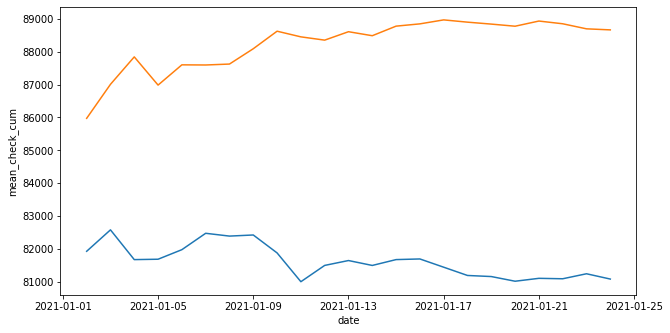

In [70]:
# ваш код здесь
fig = plt.figure(figsize=(8, 4))

ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='conversion_cum', data=df4[df4.group=='A'],  ax=ax)
sns.lineplot(x='date', y='conversion_cum', data=df4[df4.group=='B'],  ax=ax)
sns


fig = plt.figure(figsize=(8, 4))

ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='mean_check_cum', data=df4[df4.group=='A'],  ax=ax)
sns.lineplot(x='date', y='mean_check_cum', data=df4[df4.group=='B'],  ax=ax)

ваши выводы здесь -  Можно назвать A/B-тест завершенным - стабилизировались значения метрик во времени. Как соотносятся кумулятивные показатели в каждой группе: конверсия в группе А выше, средний чек выше в груупе В.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [71]:
# ваш код здесь
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(df4[df4.group=='A'].conversion)
shapiro_result_b = shapiro(df4[df4.group=='B'].conversion)
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.29
p-value группы B 0.91
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


In [72]:
from scipy.stats import mannwhitneyu
# нулевая и альтернативная гипотезы
H0 = 'Конверсия в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = mannwhitneyu(
    df4[df4.group=='A'].conversion, 
    df4[df4.group=='B'].conversion,
    alternative='greater',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсия в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь - p-value:  0.12
Принимаем нулевую гипотезу. Конверсия в группах А и B равны

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [73]:
# ваш код здесь
n = len(df4[df4.group=='A']) # размер выборки
x_mean = df4[df4.group=='A'].conversion.mean() # выборочное среднее
sigma = df4[df4.group=='A'].conversion.std() # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое
print(z_crit)

eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound, 2), round(upper_bound, 2)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал A: {}'.format(confidence_interval)) # выводим результат
# lower_bound
# eps
# sigma

n = len(df4[df4.group=='B']) # размер выборки
x_mean = df4[df4.group=='B'].conversion.mean() # выборочное среднее
sigma = df4[df4.group=='B'].conversion.std() # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое
print(z_crit)

eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound, 2), round(upper_bound, 2)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал B: {}'.format(confidence_interval)) # выводим результат

1.959963984540054
Доверительный интервал A: (11.88, 12.2)
1.959963984540054
Доверительный интервал B: (11.73, 12.07)


In [74]:
#фильтруем данные группы А
a_data = df4[df4.group=='A']
#фильтруем данные группы B
b_data = df4[df4.group=='B']

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    # print( xp[0] * (1 - xp[0])/n[0], xp[1] * (1 - xp[1])/n[1] )
    lower_bound = diff - eps[0] # левая (нижняя) граница
    upper_bound = diff + eps[0] # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    # print(xp, diff, eps, lower_bound, upper_bound)
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [len(a_data), len(b_data)]
# выборочная пропорция групп A и B
xp = [a_data['conversion'].mean()/n[0], b_data['conversion'].mean()/n[0]]
# строим доверительный интервал для разности конверсий

diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-29.51, 28.24)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [75]:
# ваши выводы здесь
# перекрытие есть, статистической разницы нет

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [76]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(df3[df3.group=='A'].mean_check)
shapiro_result_b = shapiro(df3[df3.group=='B'].mean_check)
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [77]:
# ваш код здесь
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Средний чек в группах одинаково'
H1 = 'Средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=df3[df3.group=='A'].mean_check,
    b=df3[df3.group=='B'].mean_check, 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Средний чек в группах одинаково
Альтернативная гипотеза. H1: Средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [78]:
# ваши выводы здесь
# Есть статистическая разница между ежедневными средними чеками в группах А и B

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [81]:
# ваш код здесь
a=df3[df3.group=='A'].mean_check
b=df3[df3.group=='B'].mean_check

from scipy.stats import t
def mf(a):
  n = len(a) # размер выборки
  k = n - 1 # число степеней свободы
  x_mean = a.mean() # выборочное среднее
  x_std = a.std() # выборочное стандартное отклонение
  gamma = 0.95 # уровень надёжности
  alpha = 1 - gamma # уровень значимости
  t_crit = -t.ppf(alpha/2, k) # t-критическое

  eps = t_crit * x_std/(n ** 0.5) # погрешность
  lower_bound = x_mean - eps # левая (нижняя) граница
  upper_bound = x_mean + eps # правая (верхняя) граница
  confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
  print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

mf(a)
mf(b)

Доверительный интервал: (79630, 82308)
Доверительный интервал: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [82]:
# ваши выводы здесь
# нет между ними пересечения

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

In [ ]:
# 2й вариант лучше из-за большего чека